# A workflow to find outlier expansions

## Authors in alphabetical order

- [Madeline Couse, SickKids](mailto:madeline.couse@sickkids.ca)
- [Giulia Del Gobbo, CHEO](mailto:gdelgobbo@cheo.on.ca)
- [Egor Dolzhenko, PacBio](mailto:edolzhenko@pacificbiosciences.com)
- [Adam English, BCM](mailto:adam.english@bcm.edu)
- [Tom Mokveld, PacBio](mailto:tmokveld@pacificbiosciences.com)

## Introduction

Suppose that you want to look for repeat expansions in one or more of your case samples relative to a set of controls. Let's assume that you have already aligned the reads, ran TRGT, and merged the results into an allele database file `alleles.gz` that has three columns: repeat id, sample id, and allele sequences. Let's use the next code block to set the path to your allele database and also define ids of case samples.  

## Setup

Create directories for temporary files and the final output:

In [1]:
from pathlib import Path
scratch_path = Path("scratch").mkdir(exist_ok=True)
output_path = Path("output").mkdir(exist_ok=True)

Download sample data containing repeats from chr9 with some (artificially added) expansions      

In [2]:
%%bash

wget -nv -P input/ https://github.com/tandem-repeat-workflows/find-outlier-expansions/raw/main/data/alleles.gz

2023-11-12 16:02:18 URL:https://raw.githubusercontent.com/tandem-repeat-workflows/find-outlier-expansions/main/data/alleles.gz [30384571/30384571] -> "input/alleles.gz" [1]


In [3]:
alleles_path = Path("input/alleles.gz").resolve(strict=True)

case_ids = ["HG00280", "HG00438", "HG00621"] # Assume that all other samples are controls

Now let's confirm that allele database file has the expected structure:

In [4]:
! zcat < {alleles_path} | head -n 3

chr9_100000411_100000479_A	HG00099	AGTGATAAAGCAAGATCCTGTATCAAAAAAAAAAAAAAAAAAACTTTCTCCCTTCTTCAATTTTTTGG,AGTGATAAAGCAAGATCCTGTATCAAAAAAAAAAAAAAAAAACTTTCTCCCTTCTTCAATTTTTTGG
chr9_100000411_100000479_A	HG00280	AGTGATAAAGCAAGATCCTGTATCAAAAAAAAAAAAAAAAAAACTTTCTCCCTTCTTCAATTTTTTGG,AGTGATAAAGCAAGATCCTGTATCAAAAAAAAAAAAAAAAAACTTTCTCCCTTCTTCAATTTTTTGG
chr9_100000411_100000479_A	HG00323	AGTGATAAAGCAAGATCCTGTATCAAAAAAAAAAAAAAAAAACTTTCTCCCTTCTTCAATTTTTTGG,AGTGATAAAGCAAGATCCTGTATCAAAAAAAAAAAAAAAAAAAACTTTCTCCCTTCTTCAATTTTTTGG


## Find outliers

Let's create some code for extracting alleles from the database file.

In [5]:
import gzip
import itertools
import numpy as np
from collections import namedtuple

RepeatRec = namedtuple("RepeatRec", "sample short_allele long_allele")

def get_repeat_recs(path):
    def parse_alleles(group):
        alleles = list(line.decode("utf8").split() for line in group)
        alleles = [(rec[1], rec[2].split(",")) for rec in alleles]
        return alleles
    
    with gzip.open(path, "r") as file:
        for trid, group in itertools.groupby(file, key=lambda line: line.decode("utf8").split()[0]):
            alleles = parse_alleles(group)
            repeat_recs = [(s, [len(a) for a in als]) for s, als in alleles]
            repeat_recs = [RepeatRec(s, min(als), max(als)) for s, als in repeat_recs]
            
            yield trid, repeat_recs

The following code with resample quantiles.

In [6]:
def resample_quantiles(counts, num_resamples):
    """Based on https://github.com/Illumina/ExpansionHunterDenovo/blob/master/scripts/core/common.py"""
    resamples = np.random.choice(counts, len(counts) * num_resamples)
    resamples = np.split(resamples, num_resamples)

    resampled_quantiles = []
    for resample in resamples:
        quantile = np.quantile(resample, 0.95)
        resampled_quantiles.append(quantile)

    return resampled_quantiles


def get_counts_with_finite_std(counts):
    if len(set(counts)) == 1:
        return counts[:-1] + [counts[-1] + 0.1]
    return counts


def get_cutoff(quantiles):
    mean = np.mean(quantiles)
    std = max(1, np.std(quantiles))
    cutoff = mean + std
    return cutoff

In [7]:
HitRec = namedtuple("HitRec", "trid sample allele_type allele_len z_score control_range")

def get_hits(allele_type, repeat_recs):
    assert allele_type in ["long", "short"]
    allele_index = 2 if allele_type == "long" else 1
    cases, controls = {}, []
    for rec in repeat_recs:
        if rec.sample in case_ids:
            cases[rec.sample] = rec[allele_index]
        else:
            controls.append(rec[allele_index])
    quantiles = resample_quantiles(controls, 100)
    quantiles = get_counts_with_finite_std(quantiles)
    cutoff = get_cutoff(quantiles)
    
    for case, allele_len in cases.items():
        mean_control = np.mean(controls)
        std_control = np.std(controls)
        z_score = (allele_len - mean_control) / std_control
        if allele_len > cutoff:
            yield case, allele_len, z_score, (min(controls), max(controls))

hits = []
for i, (trid, repeat_recs) in enumerate(get_repeat_recs(alleles_path)):    
    for hit_type in ["long", "short"]:
        for case, allele_len, z_score, control_range in get_hits(hit_type, repeat_recs):
            hits.append(HitRec(trid, case, hit_type, allele_len, z_score, control_range))

print(f"Found {len(hits)} hits")

/var/folders/1n/dd_4rnh5289g31hyhkjqkfhc0000gn/T/ipykernel_39426/2885101820.py:19: RuntimeWarning: invalid value encountered in scalar divide
  z_score = (allele_len - mean_control) / std_control
/var/folders/1n/dd_4rnh5289g31hyhkjqkfhc0000gn/T/ipykernel_39426/2885101820.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  z_score = (allele_len - mean_control) / std_control


Found 1756 hits


In [8]:
import re
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype
from matplotlib.lines import Line2D 

In [9]:
df = pd.DataFrame(hits)
df[['chrom', 'start', 'end', '_']] = df['trid'].str.split('_', expand=True)
df.drop(columns=['_'], inplace=True)
df['start'] = df['start'].astype(int)
df['end'] = df['end'].astype(int)

# Natural sort by chromosomes and start position
sorted_chromosomes = sorted(df['chrom'].unique(), key=lambda s: [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)])
df = (df.astype({'chrom': CategoricalDtype(categories=sorted_chromosomes, ordered=True)}).sort_values(by=['chrom', 'start']))

/var/folders/1n/dd_4rnh5289g31hyhkjqkfhc0000gn/T/ipykernel_39426/3627528954.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sample_grouped = df_sample.groupby('chrom')
/var/folders/1n/dd_4rnh5289g31hyhkjqkfhc0000gn/T/ipykernel_39426/3627528954.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sample_grouped = df_sample.groupby('chrom')
/var/folders/1n/dd_4rnh5289g31hyhkjqkfhc0000gn/T/ipykernel_39426/3627528954.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True

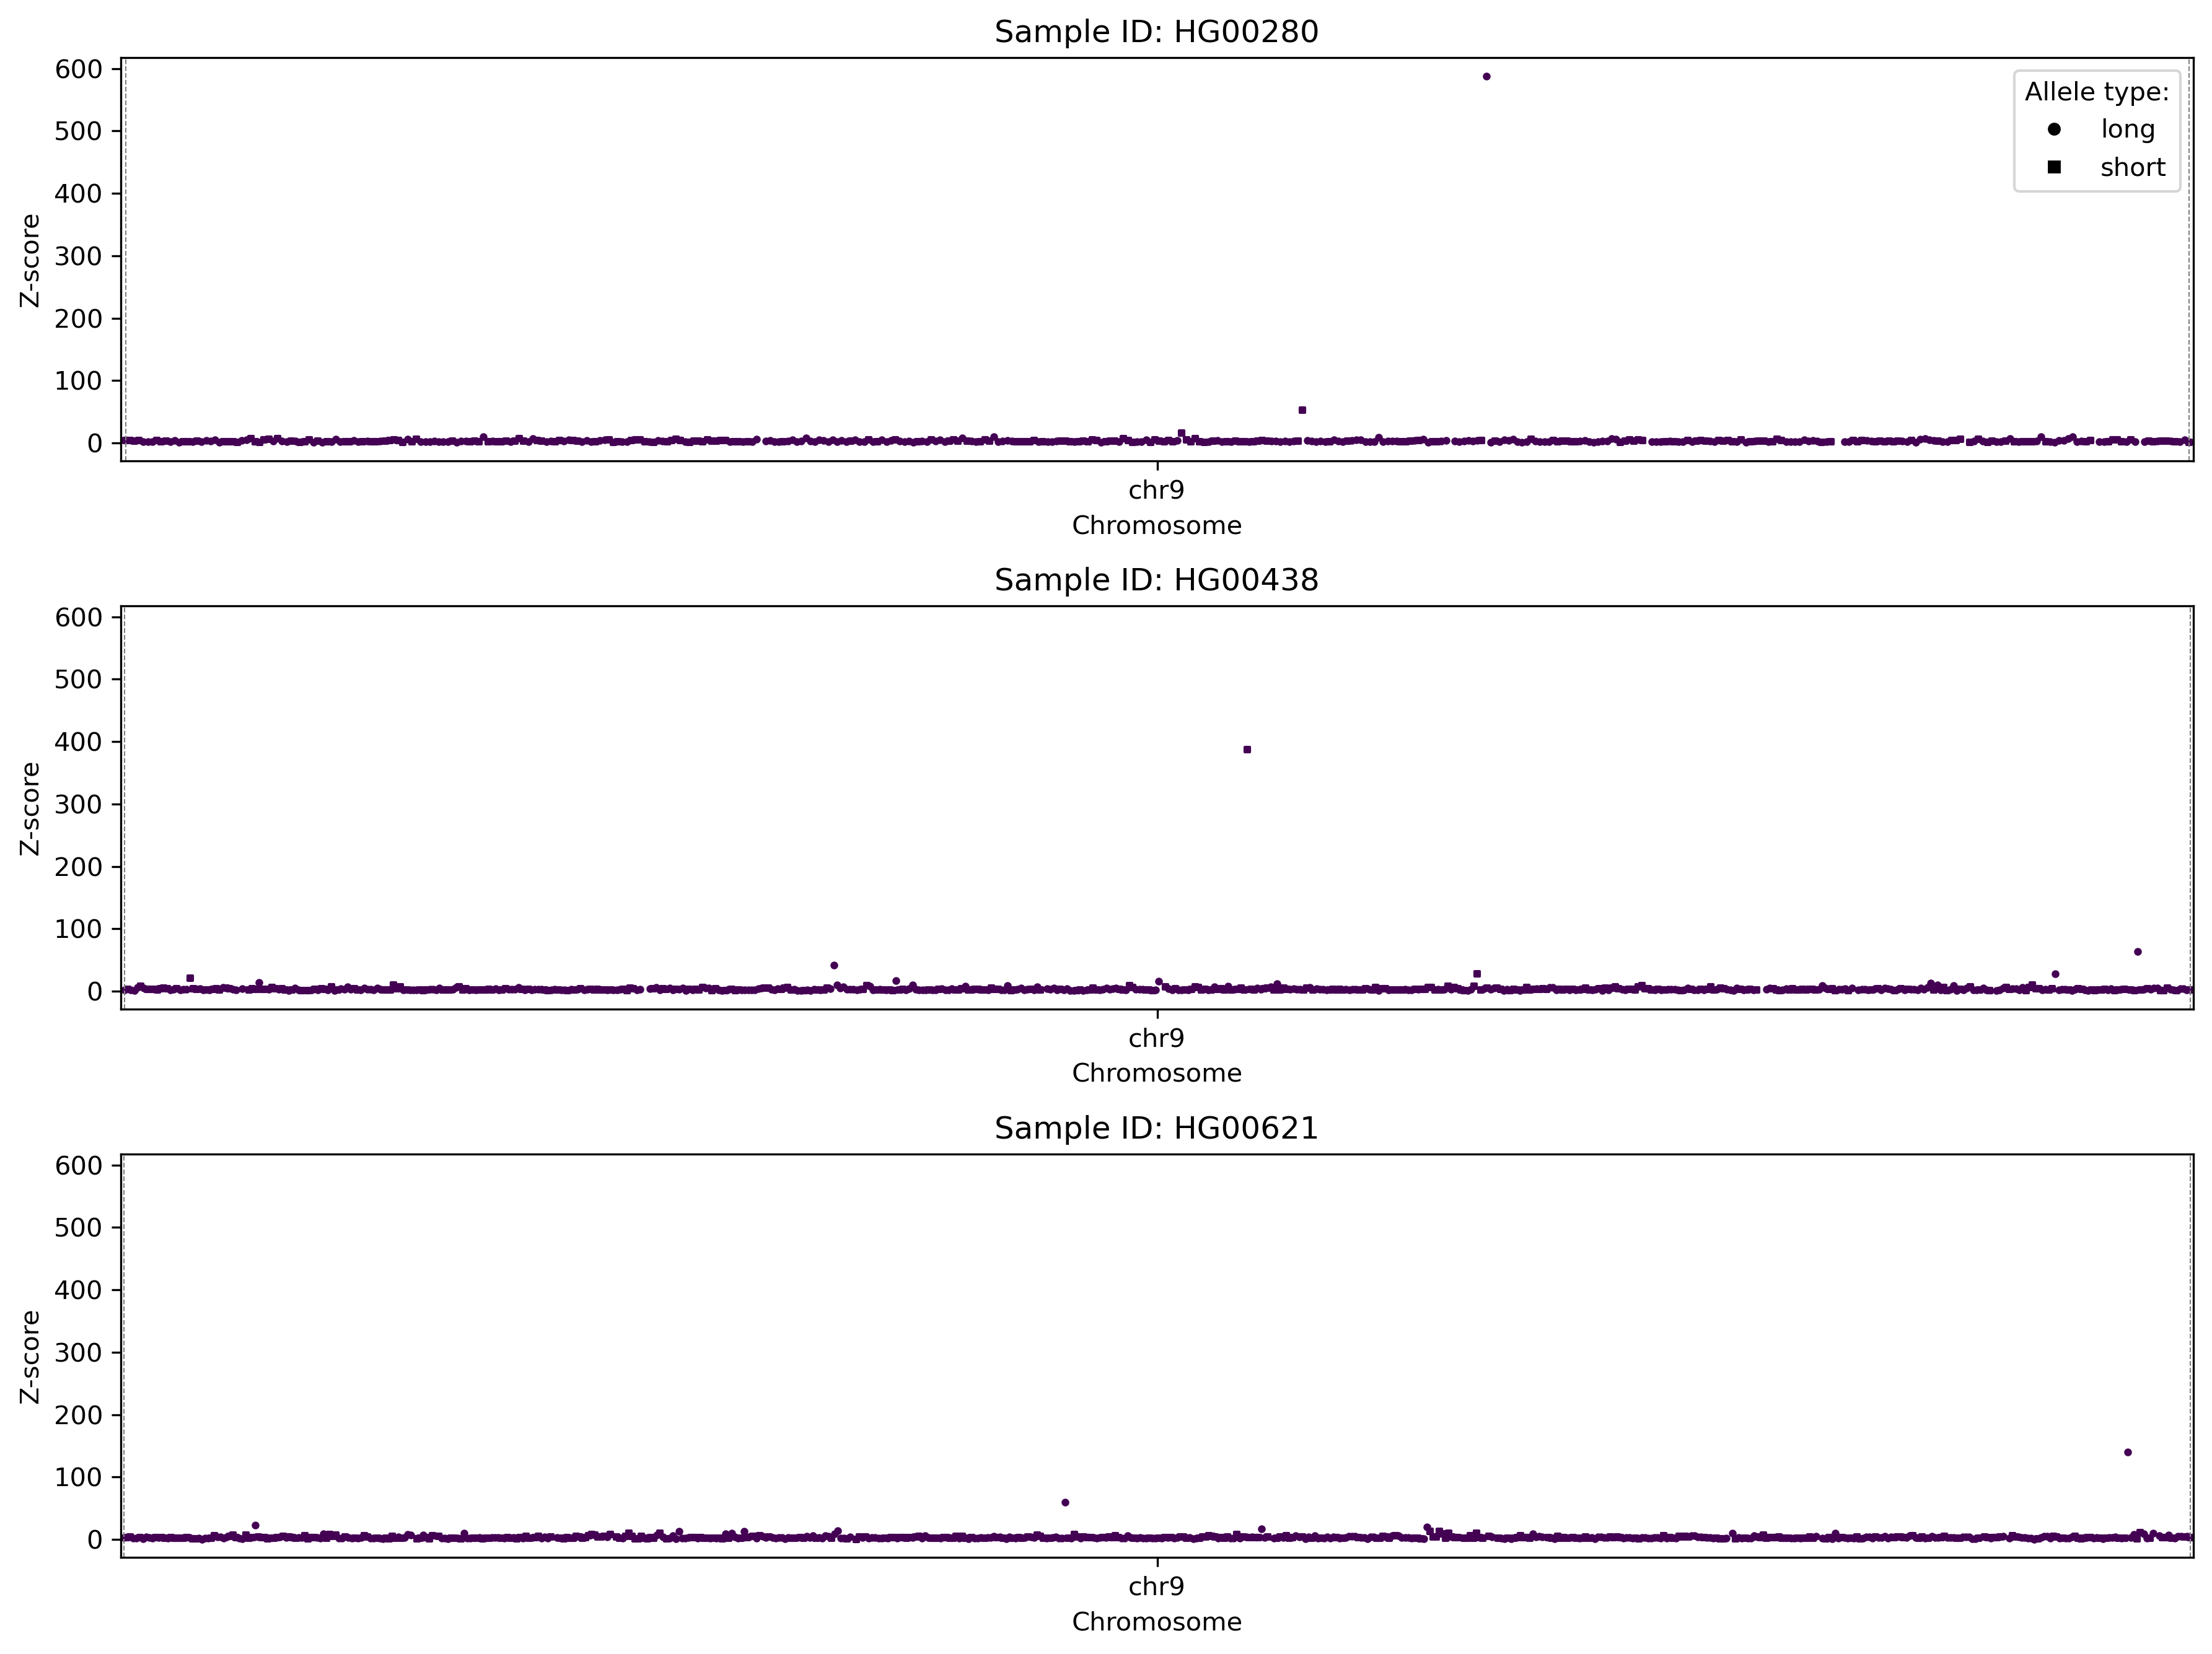

In [10]:
df_grouped_by_sample = df.groupby('sample')
n_samples = len(df['sample'].unique())

fig, axes = plt.subplots(n_samples, 1, figsize=(12, 3 * n_samples), dpi=300, sharey=True)

markers = {'long': 'o', 'short': 's'}
legend_handles = [Line2D([0], [0], marker=marker, color='w', markerfacecolor='black', markersize=6) for marker in markers.values()]
legend_labels = [str(allele) for allele in markers.keys()]

for ax_idx, (ax, (sample_id, df_sample))  in enumerate(zip(axes, df_grouped_by_sample)):
    df_sample_grouped = df_sample.groupby('chrom')
    colormap = matplotlib.colormaps['viridis'].resampled(len(df_sample_grouped))
    
    x_labels = []
    x_labels_pos = []
    line_positions = []
    df_sample['ind'] = range(len(df_sample))
    
    for i, (name, group) in enumerate(df_sample_grouped):
        if group.empty:
            continue
            
        for allele_type, marker_style in markers.items():
            allele_group = group[group['allele_type'] == allele_type]
            if allele_group.empty:
                continue
            allele_group.plot(kind='scatter', x='ind', y='z_score', color=colormap(i), s=4, ax=ax, marker=marker_style)
                
        x_labels.append(name)
        mid_pos = (group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0]) / 2)
        x_labels_pos.append(mid_pos)
        line_positions.append(group['ind'].iloc[0])
        
    line_positions.append(group['ind'].iloc[-1])    
    for pos in line_positions:
        ax.axvline(x=pos, color='grey', linestyle='--', linewidth=0.5)

    if ax_idx == 0:
        ax.legend(legend_handles, legend_labels, title='Allele type:', loc='best')
    
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels)
    ax.set_xlim([-1, len(df_sample)])
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('Z-score')
    ax.set_title(f'Sample ID: {sample_id}')
    # ax.set_yscale('log')

plt.tight_layout()
plt.show()

In [11]:
df.sort_values(['z_score'], ascending=False).head()

,trid,sample,allele_type,allele_len,z_score,control_range,chrom,start,end
654,chr9_136450174_136450265_AAAC,HG00621,short,95,inf,"(91, 91)",chr9,136450174,136450265
1033,chr9_35494000_35494083_TTTA,HG00438,short,87,inf,"(83, 83)",chr9,35494000,35494083
822,chr9_20639997_20640072_TTTTGTT,HG00621,long,77,inf,"(75, 75)",chr9,20639997,20640072
808,chr9_19948949_19949030_ATTT,HG00621,long,85,inf,"(81, 81)",chr9,19948949,19949030
319,chr9_117367479_117367554_GT,HG00280,long,77,inf,"(75, 75)",chr9,117367479,117367554
